--- Analyzing Distribution of Citing Papers per Data Paper ---

--- Summary Statistics ---
S2ORC内で引用論文が1件以上見つかったデータ論文の総数: 5,043
--------------------------------------------------
S2ORC内で引用論文が2件以上見つかったデータ論文の数: 2,305
割合: 45.71%
--------------------------------------------------

[Distribution of Citing Paper Counts (Descriptive Stats)]


count    5043.000000
mean        2.464604
std         4.882605
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       197.000000
Name: citing_paper_count, dtype: float64


[Histogram of the Distribution]


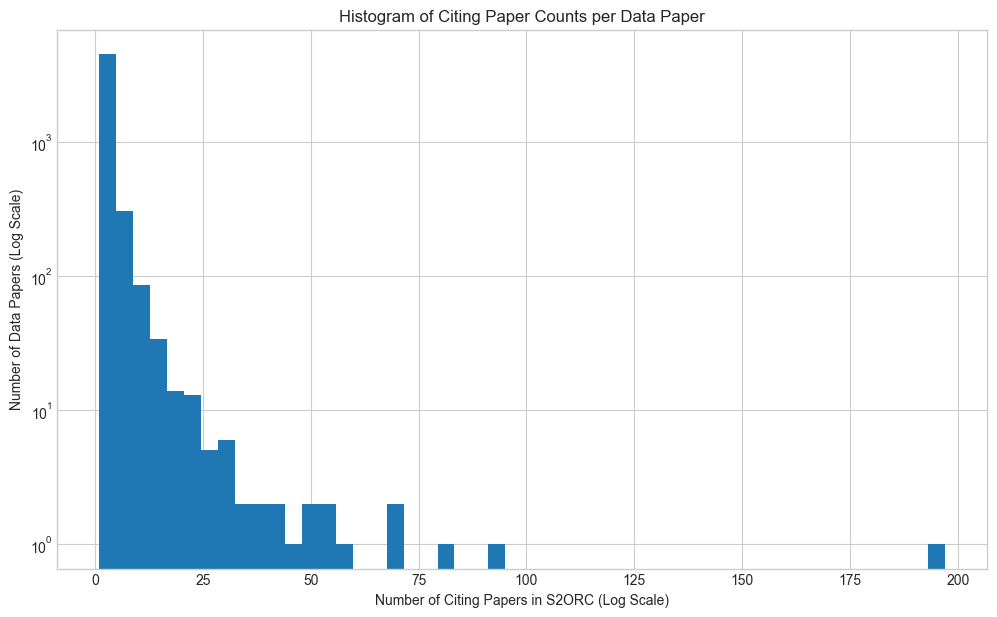

In [2]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_candidate_distribution():
    """
    positive_candidatesテーブルを分析し、データ論文ごとの
    引用論文数の分布を調査・可視化する。
    """
    print("--- Analyzing Distribution of Citing Papers per Data Paper ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # テーブルの存在を確認
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='positive_candidates'")
            if cursor.fetchone() is None:
                print("⚠️ `positive_candidates` table not found.")
                return

            # --- 2.1: データ論文ごとに引用されている件数を集計 ---
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS citing_paper_count
                FROM
                    positive_candidates
                GROUP BY
                    cited_datapaper_doi;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            if df_counts.empty:
                print("No data in `positive_candidates` table to analyze.")
                return

            # --- 2.2: 主要な統計情報を計算・表示 ---
            total_data_papers_with_citers = len(df_counts)
            
            # 引用論文が2件以上あるデータ論文をフィルタリング
            df_sufficient = df_counts[df_counts['citing_paper_count'] >= 2]
            count_sufficient = len(df_sufficient)
            
            percentage_sufficient = (count_sufficient / total_data_papers_with_citers * 100) if total_data_papers_with_citers > 0 else 0

            print("\n--- Summary Statistics ---")
            print(f"S2ORC内で引用論文が1件以上見つかったデータ論文の総数: {total_data_papers_with_citers:,}")
            print("-" * 50)
            print(f"S2ORC内で引用論文が2件以上見つかったデータ論文の数: {count_sufficient:,}")
            print(f"割合: {percentage_sufficient:.2f}%")
            print("-" * 50)
            
            print("\n[Distribution of Citing Paper Counts (Descriptive Stats)]")
            display(df_counts['citing_paper_count'].describe())

            # --- 2.3: 分布をヒストグラムで可視化 ---
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(12, 7))
            
            # データが極端に偏っているため、対数スケールで表示
            plt.hist(df_counts['citing_paper_count'], bins=50, log=True)
            
            plt.title('Histogram of Citing Paper Counts per Data Paper')
            plt.xlabel('Number of Citing Papers in S2ORC (Log Scale)')
            plt.ylabel('Number of Data Papers (Log Scale)')
            # plt.xscale('log')
            
            print("\n[Histogram of the Distribution]")
            plt.show()

    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_candidate_distribution()

In [3]:
import pandas as pd
import sqlite3
import os
import math

# --- Step 1: 設定 ---
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの分析 ---

def analyze_final_dataset_potential():
    """
    正例候補が2件以上存在するデータ論文を対象として、
    作成可能なデータセット数と正例ペアの総数を報告する。
    """
    print("--- Analyzing Final Dataset Potential (Requirement: >= 2 Positive Candidates) ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            # 1. 各データ論文がS2ORC内で何件の論文に引用されているかを集計
            query = """
                SELECT
                    cited_datapaper_doi,
                    COUNT(citing_doi) AS citing_paper_count
                FROM
                    positive_candidates
                GROUP BY
                    cited_datapaper_doi;
            """
            df_counts = pd.read_sql_query(query, conn)
            
            # 2. 引用論文が2件以上あるデータ論文のみに絞り込む
            df_eligible = df_counts[df_counts['citing_paper_count'] >= 2].copy()

            if df_eligible.empty:
                print("\nNo data papers found with 2 or more citing papers.")
                return

            # --- 2.1: 作成可能なデータセットの数を計算 ---
            num_creatable_datasets = len(df_eligible)

            # --- 2.2: 作成可能な正例ペアの総数を計算 ---
            # kC2 (k個から2個選ぶ組み合わせ) の計算式を適用
            # k * (k - 1) / 2
            df_eligible['possible_pairs'] = df_eligible['citing_paper_count'].apply(
                lambda k: k * (k - 1) // 2
            )
            
            total_positive_pairs = df_eligible['possible_pairs'].sum()

            # --- 2.3: 結果の報告 ---
            print("\n" + "="*50)
            print("--- Analysis Results ---")
            print(f"作成可能なデータセットの数 (引用論文が2件以上あるデータ論文数): {num_creatable_datasets:,}")
            print(f"作成可能な正例ペアの総数 (上記の組み合わせ合計): {int(total_positive_pairs):,}")
            print("="*50)
            
            print("\n--- Top 10 Data Papers by Potential Pair Count ---")
            display(df_eligible.sort_values(by='possible_pairs', ascending=False).head(10))


    except Exception as e:
        print(f"💥 An error occurred: {e}")

# --- 実行 ---
analyze_final_dataset_potential()

--- Analyzing Final Dataset Potential (Requirement: >= 2 Positive Candidates) ---

--- Analysis Results ---
作成可能なデータセットの数 (引用論文が2件以上あるデータ論文数): 2,305
作成可能な正例ペアの総数 (上記の組み合わせ合計): 69,202

--- Top 10 Data Papers by Potential Pair Count ---


,cited_datapaper_doi,citing_paper_count,possible_pairs
3729,10.1038/S41597-020-0453-3,197,19306
4811,10.5194/ESSD-13-4349-2021,92,4186
3783,10.1038/S41597-020-0534-3,81,3240
137,10.1007/S11558-019-09344-2,69,2346
2259,10.1016/J.DIB.2020.105340,69,2346
4879,10.5194/ESSD-14-1917-2022,57,1596
3735,10.1038/S41597-020-0462-2,55,1485
3667,10.1038/S41597-020-0369-Y,54,1431
2101,10.1016/J.DIB.2019.104863,50,1225
3580,10.1038/S41597-020-00688-8,49,1176


In [10]:
import pandas as pd
import sqlite3
import json
import os
from tqdm.auto import tqdm
from IPython.display import display, HTML

# --- Step 1: 設定 ---
# Scopusから収集した、起点となるデータ論文の全リスト
SCOPUS_DATAPAPERS_FILE = "../data/datapapers/raw/all_datapapers_raw.json"
# 以前Scopus APIで収集した、各データ論文を引用している論文のJSONファイルが保存されているディレクトリ
CITING_PAPERS_DIR = "../data/citingpapers/raw/"
# S2ORCデータベースのパス
S2ORC_DB_PATH = "../data/processed/s2orc_filtered.db"
# テストするデータ論文の数
NUM_TEST_CASES = 5

# --- Step 2: 調査の実行 ---

def find_s2orc_exclusive_citations():
    """
    Scopusの引用リストにはないが、S2ORCの引用リストには存在する
    「S2ORC独自の引用関係」を特定する。
    """
    print("--- Finding Citations Exclusive to S2ORC Database ---")

    # --- 2.1: Scopusのデータ論文リストから上位5件をサンプリング ---
    df_scopus_papers = pd.read_json(SCOPUS_DATAPAPERS_FILE)
    df_scopus_papers['citedby-count'] = pd.to_numeric(df_scopus_papers['citedby-count'], errors='coerce')
    test_cases = df_scopus_papers.dropna(subset=['eid', 'prism:doi']).nlargest(NUM_TEST_CASES, 'citedby-count')
    
    print(f"Selected Top {NUM_TEST_CASES} most cited data papers for testing.")

    # --- 2.2: 各テストケースについて検証ループ ---
    for index, data_paper in test_cases.iterrows():
        eid = data_paper['eid']
        doi = data_paper['prism:doi'].upper()
        title = data_paper['dc:title']

        print("\n" + "="*80)
        print(f"🔎 Testing Data Paper: {title} (DOI: {doi})")
        print("="*80)

        # --- 2.2.1: Scopus基準の引用DOIセットを取得 ---
        scopus_citing_filepath = os.path.join(CITING_PAPERS_DIR, f"{eid}.json")
        if not os.path.exists(scopus_citing_filepath):
            print(f"   -> Scopus citing paper file not found. Skipping.")
            continue
        with open(scopus_citing_filepath, 'r', encoding='utf-8') as f:
            scopus_citing_papers = json.load(f)
        scopus_citing_dois = {p['prism:doi'].upper() for p in scopus_citing_papers if p.get('prism:doi')}
        
        # --- 2.2.2: S2ORC基準の引用DOIセットを取得 ---
        with sqlite3.connect(S2ORC_DB_PATH) as conn:
            # `citations`テーブルを直接スキャンして、S2ORCが知る引用関係を取得
            query = "SELECT citing_doi FROM citations WHERE cited_doi = ?"
            df_s2orc_citers = pd.read_sql_query(query, conn, params=(doi,))
            s2orc_citing_dois = set(df_s2orc_citers['citing_doi'].str.upper())

        # --- 2.2.3: S2ORCにしか存在しない引用を特定（差集合） ---
        s2orc_exclusive_citations = s2orc_citing_dois - scopus_citing_dois
        
        print("\n--- Comparison Results ---")
        print(f"Citations found in Scopus file: {len(scopus_citing_dois):,}")
        print(f"Citations found in S2ORC DB: {len(s2orc_citing_dois):,}")
        print("-" * 50)
        print(f"Citations found ONLY in S2ORC (not in Scopus list): {len(s2orc_exclusive_citations):,}")
        
        if s2orc_exclusive_citations:
            print("\n--- Sample of S2ORC-exclusive citation DOIs ---")
            for exclusive_doi in list(s2orc_exclusive_citations)[:5]:
                print(exclusive_doi)

# --- 実行 ---
find_s2orc_exclusive_citations()

--- Finding Citations Exclusive to S2ORC Database ---
Selected Top 5 most cited data papers for testing.

🔎 Testing Data Paper: Version 4 of the CRU TS monthly high-resolution gridded multivariate climate dataset (DOI: 10.1038/S41597-020-0453-3)

--- Comparison Results ---
Citations found in Scopus file: 3,279
Citations found in S2ORC DB: 197
--------------------------------------------------
Citations found ONLY in S2ORC (not in Scopus list): 21

--- Sample of S2ORC-exclusive citation DOIs ---
10.3390/METEOROLOGY2010002
10.21203/RS.3.RS-373205/V1
10.31223/X52W4H
10.5194/ESD-2021-55
10.59763/MAM.AEQ.V3I.39

🔎 Testing Data Paper: ERA5-Land: A state-of-the-art global reanalysis dataset for land applications (DOI: 10.5194/ESSD-13-4349-2021)

--- Comparison Results ---
Citations found in Scopus file: 2,605
Citations found in S2ORC DB: 92
--------------------------------------------------
Citations found ONLY in S2ORC (not in Scopus list): 7

--- Sample of S2ORC-exclusive citation DOIs ---


In [9]:
import pandas as pd
import sqlite3
import os
from IPython.display import display

# --- Step 1: 設定 ---

# データベースのファイルパス
DB_PATH = "../data/processed/s2orc_filtered.db"

# --- Step 2: データベースの検証 ---

def verify_candidates_table():
    """
    positive_candidatesテーブルの内容を確認し、統計情報を表示する
    """
    print("--- Verifying `positive_candidates` Table ---")

    if not os.path.exists(DB_PATH):
        print(f"❌ Error: Database file not found at {DB_PATH}")
        return

    try:
        with sqlite3.connect(DB_PATH) as conn:
            
            # --- テーブルの存在を確認 ---
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='positive_candidates'")
            if cursor.fetchone() is None:
                print("⚠️ `positive_candidates` table not found.")
                print("   Please run the script to create and populate this table first.")
                return

            # --- 1. 全体的な統計情報を表示 ---
            print("\n--- Overall Statistics ---")
            total_count = pd.read_sql_query("SELECT COUNT(*) FROM positive_candidates", conn).iloc[0, 0]
            print(f"Total positive candidate pairs: {total_count:,}")
            
            # --- 2. テーブルのサンプルを表示 ---
            print("\n--- Sample of `positive_candidates` Table ---")
            
            # 論文タイトルも結合して、より分かりやすく表示
            query_sample = """
                SELECT
                    pc.citing_doi,
                    p_citing.title AS citing_paper_title,
                    pc.cited_datapaper_doi,
                    pc.cited_datapaper_title,
                    pc.annotation_status,
                    pc.is_pair_creatable
                FROM
                    positive_candidates pc
                LEFT JOIN
                    papers p_citing ON pc.citing_doi = p_citing.doi
                LIMIT 10;
            """
            df_sample = pd.read_sql_query(query_sample, conn)
            
            if df_sample.empty:
                print("The `positive_candidates` table is empty.")
            else:
                display(df_sample)

    except Exception as e:
        print(f"💥 An error occurred while verifying the database: {e}")

# --- 実行 ---
verify_candidates_table()

--- Verifying `positive_candidates` Table ---

--- Overall Statistics ---
Total positive candidate pairs: 12,429

--- Sample of `positive_candidates` Table ---


,citing_doi,citing_paper_title,cited_datapaper_doi,cited_datapaper_title,annotation_status,is_pair_creatable
0,10.3390/CIMB44090267,,10.1016/J.DIB.2017.08.003,Dataset on antitumor properties of silver nano...,1,0
1,10.1016/J.DIB.2021.107641,Data on nearly zero energy buildings (NZEBs) p...,10.1016/J.DIB.2019.104905,Environmental and economic data on energy effi...,1,1
2,10.1016/J.DIB.2021.107641,Data on nearly zero energy buildings (NZEBs) p...,10.1016/J.DIB.2018.02.038,Data on cost-optimal Nearly Zero Energy Buildi...,-1,1
3,10.1016/J.DIB.2021.107641,Data on nearly zero energy buildings (NZEBs) p...,10.1016/J.DIB.2017.08.043,Data on European non-residential buildings,-1,1
4,10.1016/J.DIB.2021.107641,Data on nearly zero energy buildings (NZEBs) p...,10.1016/J.DIB.2015.09.041,High performance solutions and data for nZEBs ...,-1,1
5,10.3390/V15101977,Evidence of a Protein-Coding Gene Antisense to...,10.3389/FGENE.2021.619056,Dynamic Transcriptome Sequencing of Bovine Alp...,1,1
6,10.3390/IJMS21093113,Binder-Free α-MnO 2 Nanowires on Carbon Cloth ...,10.1038/S41597-019-0178-3,Discharge performance and dynamic behavior of ...,-1,1
7,10.1371/JOURNAL.PONE.0271458,Machine learning-based estimation of riverine ...,10.1038/S41597-020-0478-7,Estimating nitrogen and phosphorus concentrati...,-1,1
8,10.3389/FPUBH.2022.873022,,10.1016/J.DIB.2020.105855,"Survey data of COVID-19-related knowledge, att...",1,1
9,10.1002/ECE3.9491,,10.1038/S41597-021-00804-2,Long-term and large-scale multispecies dataset...,-1,1
